In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Code for Josh to access data with other accounts
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
# Change directory to the shared folder
# The folder path is: '/content/drive/My Drive/path/to/shared/folder/'
shared_folder = '/content/drive/MyDrive/data'
os.chdir(shared_folder)

Mounted at /content/drive


In [2]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import time
import gc
import math

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

!pip install hdf5storage
import hdf5storage
from scipy.signal import butter, filtfilt, savgol_filter
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.fft import fft, fftfreq, fft2, rfft
from scipy.signal import iirnotch, freqz
from scipy.signal import spectrogram

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
# @title
# Adding Michael's utils.py here so we can both reference it easily

import builtins
# Monkey-patch np.unicode_ to np.str_
if not hasattr(builtins, "unicode"):
  builtins.unicode = str
  np.unicode_ = np.str_
  #importlib.reload(hdf5storage)

def import_mat(fn):
    data = hdf5storage.loadmat(fn)
    raw = data["data"]["raw"][0][0]
    epoched = data["data"]["epoched"][0][0]
    event_times = data["data"]["event_times"][0][0]
    event_names = data["data"]["event_names"][0][0]
    param_dict = {}
    param_dict["hand"] = data["data"]["hand"][0][0][0]
    param_dict["spikes"] = data["data"]["spikes"][0][0][0][0][0]
    param_dict["aligned_to"] = data["data"]["alignedTo"][0][0][0][0][0]
    param_dict["angle"] = data["data"]["angle"][0][0][0]
    param_dict["event_times"] = event_times
    param_dict["event_names"] = event_names
    return raw, epoched, param_dict


def automatic_bad_channel_detection(lfp, verbose=False):
    """
    Automatic Iterative Standard Deviation method (Komosar, et al. 2022)
    Input: lfp (channels x time x trials)
    Output: remaining_channels (i.e. "clean" channels)
    """
    remaining_channels = np.arange(lfp.shape[0])
    k = 0  # iteration counter
    sd_pk = np.inf  # std of all individual channel std's
    while sd_pk > 5:
        if verbose:
            print(sd_pk)
        if k > 0:
            remaining_channels = np.setdiff1d(remaining_channels, bad_channels_k)
        sd_k = np.median(
            np.std(lfp[remaining_channels, :, :], axis=1), axis=1
        )  # std of each channel (median across trials)
        m_k = np.median(sd_k)  # median of channel std's
        third_quartile = np.percentile(sd_k, 75)
        if sd_pk == np.std(sd_k):  # if no channels are removed (not in paper)
            break
        sd_pk = np.std(sd_k)
        bad_channels_k = []
        for ch in remaining_channels:
            sd_jk = np.std(lfp[ch, :, :])
            if sd_jk < 10e-4:
                bad_channels_k.append(ch)
            elif sd_jk > 100:
                bad_channels_k.append(ch)
            elif abs(sd_jk - m_k) > third_quartile:
                bad_channels_k.append(ch)
        k += 1
    return remaining_channels


def butter_bandpass(lowcut, highcut, fs, order=2):
    """
    Compute the filter coefficients for a Butterworth bandpass filter.
    """
    # Compute the Nyquist frequency
    nyq = 0.5 * fs
    # Compute the low and high frequencies
    low = lowcut / nyq
    high = highcut / nyq
    # Compute the filter coefficients
    b, a = butter(order, [low, high], btype="band")
    # Return the filter coefficients
    return b, a


def bandpass_filter(lfp, fs, lowcut, highcut):
    """
    Apply a bandpass filter to the LFP signal.
    """
    # Compute the filter coefficients
    b, a = butter_bandpass(lowcut, highcut, fs)
    # Apply the filter
    lfp_filtered = filtfilt(b, a, lfp, axis=1)
    # Return the filtered LFP signal
    return lfp_filtered


def trajectory_plot_2d(mua, cond_names, data_type, save_dir):
    mua_mean = np.mean(mua, axis=2)
    mua_mean = mua_mean.reshape(
        mua_mean.shape[0], mua_mean.shape[1] * mua_mean.shape[2]
    )
    pca = PCA(n_components=2)
    pca.fit(mua_mean.T)
    ev = pca.explained_variance_ratio_
    X_new = pca.transform(mua_mean.T).T
    X_new = X_new.reshape((2, mua.shape[1], mua.shape[3]))
    # plot
    f = plt.figure()
    for c in range(mua.shape[3]):
        plt.plot(X_new[0, :, c], X_new[1, :, c], label=cond_names[c])
    plt.xlabel(f"PC 1 ({ev[0] * 100:.2f}%)")
    plt.ylabel(f"PC 2 ({ev[1] * 100:.2f}%)")
    plt.legend()
    # box off
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{data_type} Trajectories")
    plt.savefig(os.path.join(save_dir, data_type + "_pca.png"))
    plt.close(f)


def classify_trajectories(mua, import_conds, nw, nt_ac):
    npc = 2  # number of principal components
    # project onto first 2 PCs
    mua_mean = np.mean(mua, axis=2)
    mua_mean = mua_mean.reshape(
        mua_mean.shape[0], mua_mean.shape[1] * mua_mean.shape[2]
    )
    pca = PCA(n_components=npc)
    pca.fit(mua_mean.T)
    pc = pca.components_
    ev = pca.explained_variance_ratio_

    projected = np.empty((npc, nw, nt_ac, len(import_conds)))
    for t in range(nt_ac):
        X = mua[:, :, t, :].reshape((mua.shape[0], mua.shape[1] * mua.shape[3])).T
        X_new = np.matmul(X, pc.T)
        X_new = X_new.reshape((nw, len(import_conds), npc))
        projected[:, :, t, :] = X_new.transpose((2, 0, 1))

    X = projected.transpose((2, 3, 0, 1))
    X = X.reshape((nt_ac * len(import_conds), X.shape[2], X.shape[3]))
    X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
    # y = np.repeat(np.arange(len(import_conds)), nt_ac)
    y = np.tile(np.arange(len(import_conds)), nt_ac)

    sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
    sss.get_n_splits(X, y)
    acc = []
    for i, (train_index, test_index) in enumerate(sss.split(X, y)):
        X_train = X[train_index, :]
        X_train = StandardScaler().fit_transform(X_train)
        X_test = X[test_index, :]
        X_test = StandardScaler().fit_transform(X_test)
        y_train = y[train_index]
        y_test = y[test_index]
        clf = LogisticRegression(max_iter=2000, random_state=0).fit(X_train, y_train)
        acc.append(clf.score(X_test, y_test))
    return acc


def box_plot(data, edge_color, fill_color):
    bp = plt.boxplot(data, patch_artist=True, showfliers=False)

    for element in ["boxes", "whiskers", "fliers", "means", "medians", "caps"]:
        plt.setp(bp[element], color=edge_color)

    for patch in bp["boxes"]:
        patch.set(facecolor=fill_color)

    return bp

#Adding Luca's functions
# Computes the spectogram of EEGs
def compute_eeg_fft_spectrogram(eeg_data, fs=1000, window_size=25, step_size=10, fmax=50):
    num_channels, num_samples = eeg_data.shape
    freqs = np.fft.rfftfreq(window_size, d=1/fs)
    max_bin = np.argmax(freqs > fmax) if np.any(freqs > fmax) else len(freqs)
    num_windows = (num_samples - window_size) // step_size + 1
    spec = np.zeros((num_channels, max_bin, num_windows))

    for ch in range(num_channels):
        for i in range(num_windows):
            start = i * step_size
            end = start + window_size
            segment = eeg_data[ch, start:end]
            fft_vals = np.abs(rfft(segment))[:max_bin]
            spec[ch, :, i] = fft_vals

    return spec, freqs[:max_bin]


# Visualize the spectogram of EEGs
def visualize_spectogram(spectrogram, title):
  plt.figure(figsize=(10, 6))
  plt.imshow(
      spectrogram,
      origin='lower',
      aspect='auto',
      cmap='viridis',
      extent=[0, spectrogram.shape[1], 0, spectrogram.shape[0]]
  )
  plt.title(title)
  plt.xlabel("Time Window")
  plt.ylabel("Frequency (Hz)")
  plt.colorbar(label="Magnitude")
  plt.tight_layout()
  plt.show()


def EEG_pipeline(X, clip_values = 500, fs = 1000, lowcut = 50, highcut = 100,
                 fmax = 100, window_size = 100, step_size = 25):
  epoched = X.copy()

  # Train/test splits
  X_Multichannel = epoched.reshape(1575, 508, X.shape[1], 1)   # We rearrange such that we have n_trials x Time x Channels
  #y = np.tile(np.arange(5), 315)  # Labels follow a repeating pattern from 0 to 4

  print("New X shape:", X_Multichannel.shape)  # (1575, 508, 256, 1)
  print("New y shape:", y.shape)  # (1575,)

  plt.plot(X_Multichannel[0, :, 0, 0])
  plt.show()


  plt.plot(X_Multichannel[0, :, :, 0])
  plt.show()

  #X_clipped = np.clip(X_Multichannel, -clip_values, clip_values)

  #print("Epoched clipped at values", clip_values)

  ffts_images = []
  for i in range(X_Multichannel.shape[0]):# Get a longer EEG window (1 second)
    real_epoched = X_Multichannel[i, :, :, 0].T  # (channels, samples)
    ffts_images.append(compute_eeg_fft_spectrogram(real_epoched, fs=fs,
            window_size=window_size, step_size=step_size, fmax=fmax)[0])
            # Note that there will be 1575 instances of 255 spectograms

  imgs_stacked = np.stack(ffts_images, axis=0)

  return ffts_images, X_Multichannel, imgs_stacked

In [3]:
# @title
# Luca code
def import_mat(fn):
    data = hdf5storage.loadmat(fn)
    raw = data["data"]["raw"][0][0]
    epoched = data["data"]["epoched"][0][0]
    event_times = data["data"]["event_times"][0][0]
    event_names = data["data"]["event_names"][0][0]
    param_dict = {}
    param_dict["hand"] = data["data"]["hand"][0][0][0]
    param_dict["spikes"] = data["data"]["spikes"][0][0][0][0][0]
    param_dict["aligned_to"] = data["data"]["alignedTo"][0][0][0][0][0]
    param_dict["angle"] = data["data"]["angle"][0][0][0]
    param_dict["event_times"] = event_times
    param_dict["event_names"] = event_names
    return raw, epoched, param_dict


def automatic_bad_channel_detection(lfp, verbose=False):
    """
    Automatic Iterative Standard Deviation method (Komosar, et al. 2022)
    Input: lfp (channels x time x trials)
    Output: remaining_channels (i.e. "clean" channels)
    """
    remaining_channels = np.arange(lfp.shape[0])
    k = 0  # iteration counter
    sd_pk = np.inf  # std of all individual channel std's
    while sd_pk > 5:
        if verbose:
            print(sd_pk)
        if k > 0:
            remaining_channels = np.setdiff1d(remaining_channels, bad_channels_k)
        sd_k = np.median(
            np.std(lfp[remaining_channels, :, :], axis=1), axis=1
        )  # std of each channel (median across trials)
        m_k = np.median(sd_k)  # median of channel std's
        third_quartile = np.percentile(sd_k, 75)
        if sd_pk == np.std(sd_k):  # if no channels are removed (not in paper)
            break
        sd_pk = np.std(sd_k)
        bad_channels_k = []
        for ch in remaining_channels:
            sd_jk = np.std(lfp[ch, :, :])
            if sd_jk < 10e-4:
                bad_channels_k.append(ch)
            elif sd_jk > 100:
                bad_channels_k.append(ch)
            elif abs(sd_jk - m_k) > third_quartile:
                bad_channels_k.append(ch)
        k += 1
    return remaining_channels


def butter_bandpass(lowcut, highcut, fs, order=2):
    """
    Compute the filter coefficients for a Butterworth bandpass filter.
    """
    # Compute the Nyquist frequency
    nyq = 0.5 * fs
    # Compute the low and high frequencies
    low = lowcut / nyq
    high = highcut / nyq
    # Compute the filter coefficients
    b, a = butter(order, [low, high], btype="band")
    # Return the filter coefficients
    return b, a


def bandpass_filter(lfp, fs, lowcut, highcut):
    """
    Apply a bandpass filter to the LFP signal.
    """
    # Compute the filter coefficients
    b, a = butter_bandpass(lowcut, highcut, fs)
    # Apply the filter
    lfp_filtered = filtfilt(b, a, lfp, axis=0)
    # Return the filtered LFP signal
    return lfp_filtered


def trajectory_plot_2d(mua, cond_names, data_type, save_dir):
    mua_mean = np.mean(mua, axis=2)
    mua_mean = mua_mean.reshape(
        mua_mean.shape[0], mua_mean.shape[1] * mua_mean.shape[2]
    )
    pca = PCA(n_components=2)
    pca.fit(mua_mean.T)
    ev = pca.explained_variance_ratio_
    X_new = pca.transform(mua_mean.T).T
    X_new = X_new.reshape((2, mua.shape[1], mua.shape[3]))
    # plot
    f = plt.figure()
    for c in range(mua.shape[3]):
        plt.plot(X_new[0, :, c], X_new[1, :, c], label=cond_names[c])
    plt.xlabel(f"PC 1 ({ev[0] * 100:.2f}%)")
    plt.ylabel(f"PC 2 ({ev[1] * 100:.2f}%)")
    plt.legend()
    # box off
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(f"{data_type} Trajectories")
    plt.savefig(os.path.join(save_dir, data_type + "_pca.png"))
    plt.close(f)


def classify_trajectories(mua, import_conds, nw, nt_ac):
    npc = 2  # number of principal components
    # project onto first 2 PCs
    mua_mean = np.mean(mua, axis=2)
    mua_mean = mua_mean.reshape(
        mua_mean.shape[0], mua_mean.shape[1] * mua_mean.shape[2]
    )
    pca = PCA(n_components=npc)
    pca.fit(mua_mean.T)
    pc = pca.components_
    ev = pca.explained_variance_ratio_

    projected = np.empty((npc, nw, nt_ac, len(import_conds)))
    for t in range(nt_ac):
        X = mua[:, :, t, :].reshape((mua.shape[0], mua.shape[1] * mua.shape[3])).T
        X_new = np.matmul(X, pc.T)
        X_new = X_new.reshape((nw, len(import_conds), npc))
        projected[:, :, t, :] = X_new.transpose((2, 0, 1))

    X = projected.transpose((2, 3, 0, 1))
    X = X.reshape((nt_ac * len(import_conds), X.shape[2], X.shape[3]))
    X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
    # y = np.repeat(np.arange(len(import_conds)), nt_ac)
    y = np.tile(np.arange(len(import_conds)), nt_ac)

    sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
    sss.get_n_splits(X, y)
    acc = []
    for i, (train_index, test_index) in enumerate(sss.split(X, y)):
        X_train = X[train_index, :]
        X_train = StandardScaler().fit_transform(X_train)
        X_test = X[test_index, :]
        X_test = StandardScaler().fit_transform(X_test)
        y_train = y[train_index]
        y_test = y[test_index]
        clf = LogisticRegression(max_iter=2000, random_state=0).fit(X_train, y_train)
        acc.append(clf.score(X_test, y_test))
    return acc


def box_plot(data, edge_color, fill_color):
    bp = plt.boxplot(data, patch_artist=True, showfliers=False)

    for element in ["boxes", "whiskers", "fliers", "means", "medians", "caps"]:
        plt.setp(bp[element], color=edge_color)

    for patch in bp["boxes"]:
        patch.set(facecolor=fill_color)

    return bp


# Placeholder for any processing we might want to do while loading
def load_data(filename):
  '''We might need separate functions. It takes a long time to upload the
  .mat files to colab, so if Colab can just find the files stored on our
  computer that might be better. Or perhaps upload the files to Google drive'''
  raw, epoched, param_dict = import_mat(filename)
  return raw, epoched, param_dict


# Placeholder for any processing we might want to do while loading
def load_all_datasets(n_classes):
  # When loading all data, we must do it seperatly due to memory constraints
  raw1, _, _ = import_mat('/content/drive/MyDrive/data/1_data_left_0.mat')
  raw2, _, _ = import_mat('/content/drive/MyDrive/data/2_data_left_45.mat')
  raw = np.concatenate((raw1, raw2), axis=2)
  del raw1, raw2
  raw3, _, _ = import_mat('/content/drive/MyDrive/data/3_data_left_90.mat')
  raw = np.concatenate((raw, raw3), axis=2)
  del raw3
  raw4, _, _= import_mat('/content/drive/MyDrive/data/4_data_left_135.mat')
  raw = np.concatenate((raw, raw4), axis=2)
  del raw4
  raw5, _, _ = import_mat('/content/drive/MyDrive/data/5_data_right_0.mat')
  raw = np.concatenate((raw, raw5), axis=2)
  del raw5
  raw6, _, _ = import_mat('/content/drive/MyDrive/data/6_data_right_45.mat')
  raw = np.concatenate((raw, raw6), axis=2)
  del raw6
  raw7, _, _ = import_mat('/content/drive/MyDrive/data/7_data_right_90.mat')
  raw = np.concatenate((raw, raw7), axis=2)
  del raw7
  raw8, _, _ = import_mat('/content/drive/MyDrive/data/8_data_right_135.mat')
  raw = np.concatenate((raw, raw8), axis=2)
  del raw8
  good_channels, bad_channel = std_bad_channels(raw)
  print("Bad Channel: ", bad_channel)
  del raw
  _, epoched1, _ = import_mat('/content/drive/MyDrive/data/1_data_left_0.mat')
  _, epoched2, _ = import_mat('/content/drive/MyDrive/data/2_data_left_45.mat')
  epoched_left = np.concatenate((epoched1, epoched2), axis=2)
  del epoched1, epoched2
  _, epoched3, _ = import_mat('/content/drive/MyDrive/data/3_data_left_90.mat')
  epoched_left = np.concatenate((epoched_left, epoched3), axis=2)
  del epoched3
  _, epoched4, _= import_mat('/content/drive/MyDrive/data/4_data_left_135.mat')
  epoched_left = np.concatenate((epoched_left, epoched4), axis=2)
  del epoched4
  if n_classes == 10:
      y_left = np.repeat(np.arange(0, 5), int(epoched_left.shape[2]))
      print("Y_LEFt", y_left.shape)
      print("epoched_left", epoched_left.shape)
  _, epoched5, _ = import_mat('/content/drive/MyDrive/data/5_data_right_0.mat')
  _, epoched6, _ = import_mat('/content/drive/MyDrive/data/6_data_right_45.mat')
  epoched_right = np.concatenate((epoched5, epoched6), axis=2)
  del epoched6
  _, epoched7, _ = import_mat('/content/drive/MyDrive/data/7_data_right_90.mat')
  epoched_right = np.concatenate((epoched_right, epoched7), axis=2)
  del epoched7
  _, epoched8, _ = import_mat('/content/drive/MyDrive/data/8_data_right_135.mat')
  epoched_right = np.concatenate((epoched_right, epoched8), axis=2)
  del epoched8
  epoched = np.concatenate((epoched_left, epoched_right), axis=2)
  print("EPOCHED SHAPE", epoched_right.shape)
  print("EPOCHED SHAPE", epoched_left.shape)
  if n_classes == 10:
      y_right = np.repeat(np.arange(5, 10), int(epoched_right.shape[2]))
      print("Y_Right", y_right.shape)
      print("epoched_right", epoched_right.shape)
      y_labels_10 = np.concatenate((y_left, y_right), axis = 0)
      print("y_labels", y_labels_10.shape)
      y_labels_5 = np.repeat(np.arange(0, 5), int(epoched.shape[2]))
      epoched = epoched[good_channels]
      return epoched, y_labels_5, y_labels_10

  else:
       y_labels = np.repeat(np.arange(0, 4), int(epoched.shape[2]))
  del epoched_left, epoched_right
  #del y_left, y_right
  epoched = epoched[good_channels]
  return epoched, y_labels, _

def std_bad_channels(lfp):
    # Automatic Iterative Standard Deviation method (Komosar, et al. 2022)
    # Adapted to Python by @madepass
    # Improved by @ManuelHernadezA
    # Arguments
    # =========
    # lfp: (n_channels, n timepoints, n_trials)
    all_channels = np.arange(lfp.shape[0])
    remaining_channels = all_channels.copy()
    k = 0  # iteration counter
    sd_pk = np.inf  # std of all individual channel std's
    std_all = np.std(lfp, axis=1)
    if len(std_all.shape) > 1:  # if lfp split into epochs (channels x time x trials)
        std_all = np.median(std_all, axis=1)
    while sd_pk > 5:
        sd_k = std_all[remaining_channels]  # std of each channel
        m_k = np.median(sd_k)  # median of channel std's
        third_quartile = np.percentile(sd_k, 75)
        temp = np.std(sd_k)
        if sd_pk == temp:  # if no channels are removed (not in paper)
            break
        sd_pk = temp
        bad_channels_k = []
        for ch in remaining_channels:
            sd_jk = std_all[ch]
            if sd_jk < 10e-1:
                bad_channels_k.append(ch)
            elif sd_jk > 100:
                bad_channels_k.append(ch)
            elif abs(sd_jk - m_k) > third_quartile:
                bad_channels_k.append(ch)
        remaining_channels = np.setdiff1d(remaining_channels, bad_channels_k)
        k += 1
    bad_channels = np.setdiff1d(all_channels, remaining_channels)
    return remaining_channels, bad_channels

# Find the avg of the previous values for all outlier values
def smooth_outliers(EEG, multiplier=2.0, prev_points=5, visualize=False, fs=2000):
    if visualize:
      EEG_original = EEG.copy()
    n_timepoints, n_channels = EEG.shape
    # We use the avg std to better remove outliers without impacting the data
    std_mean = np.mean(np.std(EEG, axis=0, keepdims=True))
    # Determine the threshold based on STD
    thresh = multiplier * std_mean
    for ch in range(n_channels):
        for t in range(n_timepoints):
          # For initial points, just clip
          if t < prev_points:
            EEG[t, ch] = np.clip(EEG[t, ch], -thresh, thresh)
            continue
          val = EEG[t, ch]
          # For outlier values, use the mean of previous values
          if np.abs(val) > thresh:
              replacement = np.mean(EEG[t - prev_points:t, ch])
              EEG[t, ch] = replacement
    # Helps us visualize the changes made, as well as the threshold
    if visualize:
        time = np.arange(n_timepoints) / fs
        for ch in range(n_channels):
            plt.figure(figsize=(10, 4))
            plt.plot(time, EEG_original[:, ch], label='Original', alpha=0.5, color='gray')
            plt.plot(time, EEG[:, ch], label='Cleaned', color='green')
            plt.axhline(thresh, linestyle='--', color='red', label='+2×STD')
            plt.axhline(thresh, linestyle='--', color='blue', label='−2×STD')
            plt.title(f"EEG Cleaning - Channel {ch}")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.tight_layout()
            plt.show()
    return EEG


def compute_eeg_spectrograms(data, fs=2000, nperseg=200, noverlap=100):
    # Data should be n_trials x n_timepoints x n_channels
    # Output should be n_trials x n_channels x spectogram
    spectograms = []
    for trial_idx in range(data.shape[0]):  # Loop over trials
        spectograms_per_trail = []
        for channel_idx in range(data.shape[2]):  # Loop over channels
            f, t, Sxx = spectrogram(data[trial_idx, :, channel_idx], fs=fs, nperseg=nperseg, noverlap=noverlap)
            spectograms_per_trail.append(Sxx)
        spectograms.append(spectograms_per_trail)
    return f, t, spectograms

def visualize_spectogram(Sxx, f, t, title = "Spectogram", normalize=True):
    # Normalize each frequency bin by its mean (or max) across time
    if normalize:
        Sxx_max = np.max(Sxx, axis=1, keepdims=True)
        Sxx_min = np.min(Sxx, axis=1, keepdims=True)
        Sxx = (Sxx - Sxx_min) / (Sxx_max - Sxx_min)
    plt.imshow(Sxx, aspect='auto', origin='lower',
              extent=[t[0], t[-1], f[0], f[-1]], cmap='viridis')

    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.title(title)

    num_yticks = len(f)
    yticks = np.linspace(f[0], f[-1], num_yticks)
    plt.yticks(yticks, labels=np.round(yticks))

    num_xticks = len(t)
    xticks = np.linspace(t[0], t[-1], num_xticks)
    plt.xticks(xticks, labels=np.round(xticks, 3), rotation=45)
    plt.show()

def visualize_spectogram_multiple(Sxx_list, f, t, normalize=True):
    # Create a plot with 5 subbplots, where each acts like visualize_spectogram
    fig, axs = plt.subplots(3, 2, figsize=(20, 20))
    num_yticks = len(f)
    yticks = np.linspace(f[0], f[-1], num_yticks)
    num_xticks = len(t)
    xticks = np.linspace(t[0], t[-1], num_xticks)
    for i in range(len(Sxx_list)):
        Sxx = Sxx_list[i]
        if normalize:
            Sxx_max = np.max(Sxx, axis=1, keepdims=True)
            Sxx_min = np.min(Sxx, axis=1, keepdims=True)
            Sxx = (Sxx - Sxx_min) / (Sxx_max - Sxx_min)
        im = axs[int(i/2)][i%2].imshow(Sxx, aspect='auto', origin='lower',
                      extent=[t[0], t[-1], f[0], f[-1]], cmap='viridis')
        axs[int(i/2)][i%2].set_title(f'State {i+1}')
        axs[int(i/2)][i%2].set_xlabel('Time (s)')
        axs[int(i/2)][i%2].set_ylabel('Frequency (Hz)')
        axs[int(i/2)][i%2].set_xticks(xticks)
        axs[int(i/2)][i%2].set_yticks(yticks)
        fig.colorbar(im, ax=axs[int(i/2)][i%2])
    plt.tight_layout()
    plt.show()

def visualize_spectogram_difference(Sxx_list, f, t, normalize=True):
    # Normalize by both spectograms!
    for i in range(len(Sxx_list)):
        print("Difference of states compared to state", i)
        Sxx_diff = []
        # We take the state we want to compare with
        Sxx_base = Sxx_list[i]
        for j in range(len(Sxx_list)):
            # We take the state we want to compare to
            Sxx_temp = Sxx_list[j]
            if normalize:
                # We normalize it by the time axis
                Sxx_diff_temp_max = np.max(np.maximum(np.max(Sxx_temp, axis=1, keepdims=True), np.max(Sxx_base, axis=1, keepdims=True)), axis=1,  keepdims=True)
                Sxx_diff_temp_min = np.min(np.minimum(np.min(Sxx_temp, axis=1, keepdims=True), np.min(Sxx_base, axis=1, keepdims=True)), axis=1, keepdims=True)
                Sxx_temp = (Sxx_temp - Sxx_diff_temp_min) / (Sxx_diff_temp_max - Sxx_diff_temp_min)
                Sxx_base = (Sxx_base - Sxx_diff_temp_min) / (Sxx_diff_temp_max - Sxx_diff_temp_min)
            # We get the abs value (we care about the distance)
            Sxx_diff_temp = np.abs(Sxx_base - Sxx_temp)
            Sxx_diff.append(Sxx_diff_temp)

        visualize_spectogram_multiple(Sxx_diff, f, t, normalize=True)


def clean_spectograms(spectograms, f, remove_freqs, fs, window_size, upper_bound):
    cleaned_spectograms = []
    lower_bound = int(math.ceil(fs / window_size / 10.0) * 10)
    lower_bound_indx = np.where(f >= lower_bound)[0][0]
    upper_bound_indx = np.where(f <= upper_bound)[0][-1]
    mask = (f >= remove_freqs-2) & (f <= remove_freqs+2)
    for trial in spectograms:
        cleaned_spectogram_per_trial = []
        for channel in trial:
            cleaned_spectogram = channel
            cleaned_spectogram[mask, :] = 0
            cleaned_spectogram = cleaned_spectogram[lower_bound_indx:upper_bound_indx]
            cleaned_spectogram_per_trial.append(cleaned_spectogram)
        cleaned_spectograms.append(cleaned_spectogram_per_trial)
    f = f[lower_bound_indx:upper_bound_indx]
    return np.array(cleaned_spectograms), f

def EEG_FFT_pipeline(fs = 2000, window_size = 200, noverlap = 100, classes = 5):
    epoched, _, y_labeled = load_all_datasets(classes)
    epoched = epoched.reshape(epoched.shape[2] * epoched.shape[3], epoched.shape[1], epoched.shape[0])   # We rearrange such that we have n_trials x Time x Channels
    #EEG_smoothed = []
    #for i in range(epoched.shape[0]):
        #EEG_smoothed.append(smooth_outliers(epoched[i, :, :]))
    #del epoched
    #EEG_smoothed = np.array(EEG_smoothed)
    EEG_cleaned = epoched
    del epoched
    y_cleaned = y_labeled
    f, t, spectograms = compute_eeg_spectrograms(EEG_cleaned, fs=fs, nperseg=window_size, noverlap = noverlap)
    cleaned_spectogram, f = clean_spectograms(spectograms, f, remove_freqs=60, fs=fs, window_size=window_size, upper_bound=500)
    del spectograms
    return f, t, cleaned_spectogram, y_cleaned

In [4]:
# @title
_, epoched1, _ = import_mat('/content/drive/MyDrive/data/1_data_left_0.mat')
_, epoched2, _ = import_mat('/content/drive/MyDrive/data/2_data_left_45.mat')
_, epoched3, _ = import_mat('/content/drive/MyDrive/data/3_data_left_90.mat')
_, epoched4, _ = import_mat('/content/drive/MyDrive/data/4_data_left_135.mat')
_, epoched5, _ = import_mat('/content/drive/MyDrive/data/5_data_right_0.mat')
_, epoched6, _ = import_mat('/content/drive/MyDrive/data/6_data_right_45.mat')
_, epoched7, _ = import_mat('/content/drive/MyDrive/data/7_data_right_90.mat')
_, epoched8, _ = import_mat('/content/drive/MyDrive/data/8_data_right_135.mat')

In [5]:
# @title
# Train/test splits
import gc

#epoched_total = np.concatenate((epoched1, epoched2, epoched3, epoched4, epoched5, epoched6, epoched7, epoched8), axis=2)
epoched_left = np.concatenate((epoched1, epoched2, epoched3, epoched4), axis=2)
epoched_right = np.concatenate((epoched5, epoched6, epoched7, epoched8), axis=2)
left_trials = epoched1.shape[2] + epoched2.shape[2] + epoched3.shape[2] + epoched4.shape[2]
right_trials = epoched5.shape[2] + epoched6.shape[2] + epoched7.shape[2] + epoched8.shape[2]
print(left_trials)
print(right_trials)

# Delete individual datasets to free memory
del epoched1, epoched2, epoched3, epoched4, epoched5, epoched6, epoched7, epoched8
del _

# Force garbage collection
gc.collect()



155
160


0

In [ ]:
# @title
# Code for smoothing
EEG_left_smoothed = np.empty_like(epoched_left)
for trial_idx in range(epoched_left.shape[2]):
    for class_idx in range(epoched_left.shape[3]):
        # Extract the time x channel data for the current trial and class
        eeg_trial_class = epoched_left[:, :, trial_idx, class_idx].T # Transpose to get (time, channels)
        # Apply smoothing and assign to the new array
        EEG_left_smoothed[:, :, trial_idx, class_idx] = smooth_outliers(eeg_trial_class).T # Transpose back to original shape

del epoched_left

EEG_right_smoothed = np.empty_like(epoched_right)
for trial_idx in range(epoched_right.shape[2]):
    for class_idx in range(epoched_right.shape[3]):
        # Extract the time x channel data for the current trial and class
        eeg_trial_class = epoched_right[:, :, trial_idx, class_idx].T # Transpose to get (time, channels)
        # Apply smoothing and assign to the new array
        EEG_right_smoothed[:, :, trial_idx, class_idx] = smooth_outliers(eeg_trial_class).T # Transpose back to original shape

del epoched_right

In [6]:
# Using when trying to make spectrograms before feeding autoencoder

from scipy.signal import spectrogram
import numpy as np

def compute_eeg_spectrograms(data, fs=2000, nperseg=200, noverlap=100):
    """
    Compute spectrograms for each neuron in EEG data.

    Parameters:
    - data: ndarray of shape (256, 508, num_trials, 5)
    - fs: Sampling frequency
    - nperseg: Length of each FFT segment
    - noverlap: Overlap between segments

    Returns:
    - spectrograms: ndarray of shape (num_total_trials, 256, n_freq_bins, n_time_windows)
    """
    n_neurons, n_time, n_trials, n_classes = data.shape
    all_specs = []

    for cls in range(n_classes):
        for trial in range(n_trials):
            trial_specs = []
            for neuron in range(n_neurons):
                signal = data[neuron, :, trial, cls]
                f, t, Sxx = spectrogram(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
                trial_specs.append(Sxx)  # Sxx shape: (n_freq_bins, n_time_windows)
            trial_specs = np.stack(trial_specs, axis=0)  # Shape: (256, n_freq_bins, n_time_windows)
            all_specs.append(trial_specs)

    all_specs = np.stack(all_specs, axis=0)  # Shape: (n_total_trials, 256, n_freq_bins, n_time_windows)
    return f, all_specs.transpose(0, 2, 3, 1)


In [7]:
# @title
fl, specs_left = compute_eeg_spectrograms(epoched_left)
fr, specs_right = compute_eeg_spectrograms(epoched_right)
#fl, specs_left = compute_eeg_spectrograms(EEG_left_smoothed)
#fr, specs_right = compute_eeg_spectrograms(EEG_right_smoothed)
print(specs_left.shape)
print(specs_right.shape)

(775, 101, 4, 256)
(800, 101, 4, 256)


In [8]:
y_left = np.repeat(np.arange(0, 5), epoched_left.shape[2])
zeros = np.zeros(epoched_right.shape[2])
y_part_right = np.repeat(np.arange(5, 9), epoched_right.shape[2])
y_right = np.concatenate([zeros, y_part_right])
y_total = np.concatenate((y_left, y_right), axis=0)

X_total = np.concatenate((specs_left, specs_right), axis=0)
X_total = X_total.transpose(0, 3, 1, 2)
X_final, f = clean_spectograms(X_total, fl, remove_freqs=60, fs=2000, window_size=200, upper_bound=500)
X_final = X_final.transpose(0, 2, 3, 1)
print(X_final.shape)

channels_to_remove = [0, 1, 3, 5, 9, 30, 52, 63, 81, 88, 92]
channels_to_keep = [i for i in range(X_final.shape[-1]) if i not in channels_to_remove]
X_final = X_final[:, :, :, channels_to_keep]

print(X_final.shape)

(1575, 49, 4, 256)
(1575, 49, 4, 245)


In [9]:
del X_total, specs_left, specs_right, y_left, y_right, fl, fr
gc.collect()

0

In [10]:
# @title
X_train, X_test, y_train, y_test = train_test_split(X_final, y_total, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1260, 49, 4, 245)
(315, 49, 4, 245)
(1260,)
(315,)


In [11]:
del epoched_left, epoched_right
gc.collect()

0

In [12]:
# Putting it all together
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Lambda
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.layers import Permute, TimeDistributed, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape, LSTM

def build_autoencoder(input_shape, dim_size):
  model = models.Sequential(name="Encoder")
  model.add(layers.Input(shape=input_shape))
  model.add(layers.Conv2D(128, (5, dim_size), padding='same', activation='relu', name='encoded_1'))
  model.add(layers.Conv2D(64, (5, dim_size), padding='same', activation='relu'))
  model.add(layers.Conv2D(32, (3, dim_size), padding='same', activation='relu', name='bottle'))
  return model

def build_cnn(input_shape, layer1, kernel1, layer2, kernel2, pool_size,
              denselayer, layer_dropout, end_dropout, num_classes=9):
  model = Sequential(name="ConvClassifier")
  model.add(InputLayer(input_shape=input_shape))
  model.add(Conv2D(layer1, kernel_size=kernel1, activation='relu', padding='same'))
  model.add(Conv2D(layer1, kernel_size=kernel1, activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
  model.add(Dropout(layer_dropout))
  model.add(Conv2D(layer2, kernel_size=kernel2, activation='relu', padding='same'))
  model.add(Conv2D(layer2, kernel_size=kernel2, activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
  model.add(Dropout(layer_dropout))
  model.add(Flatten())
  model.add(Dense(denselayer, activation='relu'))
  model.add(Dropout(end_dropout))
  model.add(Dense(num_classes, activation='softmax'))
  return model

def build_cnn_lstm(input_shape, layer1, kernel1, layer2, kernel2, pool_size, lstm_size,
              denselayer, cnn_dropout, lstm_dropout, end_dropout, num_classes=9):
  model = Sequential()

  model.add(InputLayer(input_shape=input_shape))
  model.add(Conv2D(layer1, kernel1, activation='relu', padding='same'))
  model.add(Conv2D(layer1, kernel1, activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size))
  model.add(Dropout(cnn_dropout))

  model.add(Conv2D(layer2, kernel2, activation='relu', padding='same'))
  model.add(Conv2D(layer2, kernel2, activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size))
  model.add(Dropout(cnn_dropout))

  # Flattening CNN output
  model.add(Flatten())

  # Reshaping for LSTM (time steps, features)
  model.add(Reshape((-1, layer2)))  # Adjust the second dimension based on your CNN output size

  # LSTM Layers (Temporal Sequence Learning)
  model.add(LSTM(lstm_size, return_sequences=True))
  model.add(LSTM(lstm_size))
  model.add(Dropout(lstm_dropout))

  # Dense Layers for Classification
  model.add(Dense(denselayer, activation='relu'))
  model.add(Dropout(end_dropout))
  model.add(Dense(9, activation='softmax'))  # Assuming 10 classes for classification

  return model

def build_parallel_model(input_shape, layer1, kernel1, layer2, kernel2, pool_size, lstm_size,
                         cnn_dense, denselayer, cnn_dropout, lstm_dropout, end_dropout, num_classes=9):
  input = keras.Input(shape=input_shape, name='input')

  # CNN branch
  x = Conv2D(layer1, kernel_size=kernel1, activation='relu', padding='same')(input)
  x = Conv2D(layer1, kernel_size=kernel1, activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=pool_size)(x)
  x = Conv2D(layer2, kernel_size=kernel2, activation='relu', padding='same')(x)
  x = Conv2D(layer2, kernel_size=kernel2, activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=pool_size)(x)
  x = Flatten()(x)
  cnn_out = Dense(cnn_dense, activation='relu')(x)
  cnn_out = Dropout(cnn_dropout)(cnn_out)

  # LSTM branch: reshape to (time_steps, freq_bins)
  y = Reshape((input_shape[1], input_shape[0] * input_shape[2]))(input)
  lstm_out = LSTM(lstm_size, return_sequences=True)(y)
  lstm_out = LSTM(lstm_size, return_sequences=False)(y)
  lstm_out = Dropout(lstm_dropout)(lstm_out)

  # Combine branches
  combined = concatenate([cnn_out, lstm_out], axis=-1)

  # Final classification layers
  z = Dense(denselayer, activation='relu')(combined)
  z = Dropout(end_dropout)(z)
  output = Dense(num_classes, activation='softmax', name='classification_output')(z)

  model = models.Model(inputs=input, outputs=output)
  return model

def build_cnn_model(dim_size, layer1, kernel1, layer2, kernel2, pool_size,
              denselayer, layer_dropout, end_dropout, num_classes=9):
    input_layer = keras.Input(shape=(49, 4, 245))  # EEG trials

    encoder = build_autoencoder((49, 4, 245), dim_size)

    encoded_input = encoder(input_layer)
    cnn_input_shape = encoded_input.shape[1:]
    cnn = build_cnn(cnn_input_shape, layer1, kernel1, layer2, kernel2, pool_size,
              denselayer, layer_dropout, end_dropout, num_classes=num_classes)

    outputs = cnn(encoded_input)

    model = models.Model(inputs=input_layer, outputs=outputs, name="CNN")
    return model

def build_full_model(dim_size, layer1, kernel1, layer2, kernel2, pool_size, lstm_size,
              denselayer, cnn_dropout, lstm_dropout, end_dropout, num_classes):
    input_layer = keras.Input(shape=(49, 4, 245))  # EEG trials

    encoder = build_autoencoder((49, 4, 245), dim_size)

    encoded_input = encoder(input_layer)
    cnn_input_shape = encoded_input.shape[1:]
    cnn = build_cnn_lstm(cnn_input_shape, layer1, kernel1, layer2, kernel2, pool_size, lstm_size,
              denselayer, cnn_dropout, lstm_dropout, end_dropout, num_classes=num_classes)

    outputs = cnn(encoded_input)

    model = models.Model(inputs=input_layer, outputs=outputs, name="Parallel")
    return model

def build_full_parallel(dim_size, layer1, kernel1, layer2, kernel2, pool_size, lstm_size,
                         cnn_dense, denselayer, cnn_dropout, lstm_dropout, end_dropout, num_classes=9):
    input_layer = keras.Input(shape=(49, 4, 245))  # EEG trials

    encoder = build_autoencoder((49, 4, 245), dim_size)

    encoded_input = encoder(input_layer)
    cnn_input_shape = encoded_input.shape[1:]

    parallel = build_parallel_model(cnn_input_shape, layer1, kernel1, layer2,
                                    kernel2, pool_size, lstm_size, cnn_dense,
                                    denselayer, cnn_dropout, lstm_dropout,
                                    end_dropout, num_classes=num_classes)

    outputs = parallel(encoded_input)

    model = models.Model(inputs=input_layer, outputs=outputs)
    return model


In [ ]:
# @title
# Code to test single model

#model = build_full_parallel(dim_size=1, layer1=16, kernel1=(5,3), layer2=32, kernel2=(7,3), pool_size=(2,2), lstm_size=64, cnn_dense=64, denselayer=64, cnn_dropout=0.5, lstm_dropout=0.5, end_dropout=0.5, num_classes=9)
model = build_cnn_model(dim_size=1, layer1=32, kernel1=(5,3), layer2=64, kernel2=(5,3), denselayer=128, pool_size=(2,2), layer_dropout=0.5, end_dropout=0.5, num_classes=9)
#model = build_full_model(dim_size=1, layer1=32, kernel1=(5,3), layer2=64, kernel2=(5,3), pool_size=(2,2), lstm_size=64, denselayer=128, cnn_dropout=0.2, lstm_dropout=0.2, end_dropout=0.5, num_classes=9)
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                              restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                          patience=5, min_lr=0.00001)

# Compile with current learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train with early stopping
history = model.fit(
    X_train, y_train,
    callbacks=[early_stopping, reduce_lr],
    validation_split=0.2,
    batch_size=64,
    epochs=150,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 510ms/step - accuracy: 0.1710 - loss: 2.4493 - val_accuracy: 0.1825 - val_loss: 2.1575 - learning_rate: 0.0010
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.2104 - loss: 3.1261 - val_accuracy: 0.1825 - val_loss: 2.1264 - learning_rate: 0.0010
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2007 - loss: 3.8034 - val_accuracy: 0.1825 - val_loss: 2.0728 - learning_rate: 0.0010
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.2274 - loss: 3.4909 - val_accuracy: 0.1825 - val_loss: 1.9906 - learning_rate: 0.0010
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.2449 - loss: 2.0689 - val_accuracy: 0.3135 - val_loss: 1.8529 - learning_rate: 0.0010
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.2763 - loss: 2.0552 - val_accuracy: 0.3730 - val_loss: 1.7202 - learning_rate: 0.0010
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3397 - loss: 2.1926 

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step


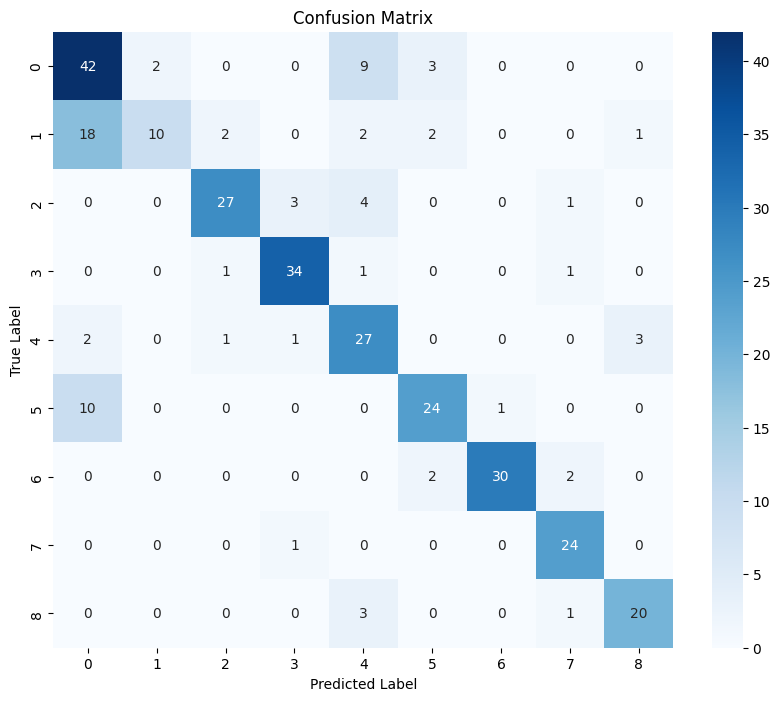

Accuracy:  0.7555555555555555
Precision:  0.7943600918041117
Recall:  0.7646199981494098
              precision    recall  f1-score   support

         0.0       0.58      0.75      0.66        56
         1.0       0.83      0.29      0.43        35
         2.0       0.87      0.77      0.82        35
         3.0       0.87      0.92      0.89        37
         4.0       0.59      0.79      0.68        34
         5.0       0.77      0.69      0.73        35
         6.0       0.97      0.88      0.92        34
         7.0       0.83      0.96      0.89        25
         8.0       0.83      0.83      0.83        24

    accuracy                           0.76       315
   macro avg       0.79      0.76      0.76       315
weighted avg       0.78      0.76      0.75       315



In [ ]:
# @title
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sns

classes = np.arange(0, 9)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')


cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print(classification_report(y_test, y_pred_classes))

In [26]:
# PCA decomposition

n_samples, n_freq, n_time, n_channels = X_final.shape
X = X_final.reshape(-1, n_channels)

# Apply PCA to reduce channels (e.g., 3 → 2)
pca = PCA(n_components=32)
X_reduced = pca.fit_transform(X)  # Shape: (100*128*50, 2)

# Reshape back to (num_samples, freq, time_window, k)
reduced_data = X_reduced.reshape(n_samples, n_freq, n_time, 32)
print("Reduced shape:", reduced_data.shape)  # (100, 128, 50, 2)

X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(reduced_data, y_total, test_size=0.2, random_state=42)
print(X_pca_train.shape)
print(X_pca_test.shape)

Reduced shape: (1575, 49, 4, 32)
(1260, 49, 4, 32)
(315, 49, 4, 32)


In [ ]:
# Preparing grid search for PCA data
from keras import backend as K
from itertools import product

# Define parameter options
param_options = {
    'input_shape': [(49, 4, 32)],
    'layer1': [16, 32],
    'kernel1': [(3, 3), (5,3)],
    'layer2': [32, 64],
    'kernel2': [(5,3), (7,3)],
    'pool_size': [(2,2), (3, 3)],
    'denselayer': [64, 128],
    'layer_dropout': [0.3, 0.4],
    'end_dropout': [0.4, 0.5],
    'batch_size': [128],
    'epochs': [100],
}

# Generate all combinations
all_params = [dict(zip(param_options.keys(), values))
             for values in product(*param_options.values())]

# Code to start gridsearch from place where colab GPU finishes
'''last_completed_parallel = {'dim_size': 1, 'layer1': 16, 'kernel1': (5, 3),
                                          'layer2': 64, 'kernel2': (7, 3), 'cnn_dense': 64,
                                           'denselayer': 128, 'pool_size': (2, 2), 'lstm_size': 128,
                                           'cnn_dropout': 0.4, 'lstm_dropout': 0.4, 'end_dropout': 0.5,
                                           'batch_size': 128, 'epochs': 100}
start_index = next(i for i, param in enumerate(all_params) if param == last_completed) + 1'''

best_score = 0
best_params = None

results = []

#for params in all_params[start_index:]:
for params in all_params:
    print(f"\nTesting params: {params}")

    tf.keras.backend.clear_session()
    tf.config.run_functions_eagerly(True)

    # Build model
    model = build_cnn(
        input_shape = params['input_shape'],
        layer1 = params['layer1'],
        kernel1 = params['kernel1'],
        layer2 = params['layer2'],
        kernel2 = params['kernel2'],
        pool_size = params['pool_size'],
        denselayer = params['denselayer'],
        layer_dropout = params['layer_dropout'],
        end_dropout = params['end_dropout'],
    )

    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                                  restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=5, min_lr=0.00001)

    # Compile with current learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train with early stopping
    history = model.fit(
        X_pca_train, y_pca_train,
        callbacks=[early_stopping, reduce_lr],
        validation_split=0.2,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        verbose=0
    )

    # Get best validation accuracy
    val_acc = max(history.history['val_accuracy'])

    results.append({
        **params,
        'val_acc': val_acc
    })

    if val_acc > best_score:
        best_score = val_acc
        best_params = params
        print(f"New best val_acc: {best_score:.4f}")

print("\nFinal best parameters:")
print(best_params)
print(f"Best validation accuracy: {best_score:.4f}")




Testing params: {'input_shape': (49, 4, 32), 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'denselayer': 64, 'layer_dropout': 0.3, 'end_dropout': 0.4, 'batch_size': 128, 'epochs': 100}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


New best val_acc: 0.7421

Testing params: {'input_shape': (49, 4, 32), 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'denselayer': 64, 'layer_dropout': 0.3, 'end_dropout': 0.5, 'batch_size': 128, 'epochs': 100}

Testing params: {'input_shape': (49, 4, 32), 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'denselayer': 64, 'layer_dropout': 0.4, 'end_dropout': 0.4, 'batch_size': 128, 'epochs': 100}

Testing params: {'input_shape': (49, 4, 32), 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'denselayer': 64, 'layer_dropout': 0.4, 'end_dropout': 0.5, 'batch_size': 128, 'epochs': 100}

Testing params: {'input_shape': (49, 4, 32), 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'denselayer': 128, 'layer_dropout': 0.3, 'end_dropout': 0.4, 'batch_size': 128, 'epochs': 100}
New best val_acc: 0.7579

Testing params: {'input_shape': (49, 4, 

In [ ]:
# @title
# Preparing grid search
from keras import backend as K
from itertools import product

# Define parameter options
param_options = {
    'dim_size': [1],
    'layer1': [16, 32],
    'kernel1': [(3, 3), (5,3)],
    'layer2': [32, 64],
    'kernel2': [(5,3), (5,3)],
    'pool_size': [(2,2)],
    'lstm_size': [32, 64, 128],
    'denselayer': [64, 128],
    'cnn_dropout': [0.3, 0.4],
    'lstm_dropout': [0.3, 0.4],
    'end_dropout': [0.4, 0.5],
    'batch_size': [128],
    'epochs': [100],
}

# Generate all combinations
all_params = [dict(zip(param_options.keys(), values))
             for values in product(*param_options.values())]

# Code to start gridsearch from place where colab GPU finishes
'''last_completed_parallel = {'dim_size': 1, 'layer1': 16, 'kernel1': (5, 3),
                                          'layer2': 64, 'kernel2': (7, 3), 'cnn_dense': 64,
                                           'denselayer': 128, 'pool_size': (2, 2), 'lstm_size': 128,
                                           'cnn_dropout': 0.4, 'lstm_dropout': 0.4, 'end_dropout': 0.5,
                                           'batch_size': 128, 'epochs': 100}
start_index = next(i for i, param in enumerate(all_params) if param == last_completed) + 1'''

# For full model
'''last_completed_full = {'dim_size': 1, 'layer1': 16, 'kernel1': (3, 3), 'layer2': 64,
                       'kernel2': (5, 3), 'pool_size': (2, 2), 'lstm_size': 128, 'denselayer': 64,
                       'cnn_dropout': 0.4, 'lstm_dropout': 0.4, 'end_dropout': 0.4, 'batch_size': 128, 'epochs': 100}
start_index = next(i for i, param in enumerate(all_params) if param == last_completed_full) + 1'''

best_score = 0
best_params = None

results = []

for params in all_params[start_index:]:
#for params in all_params:
    print(f"\nTesting params: {params}")

    tf.keras.backend.clear_session()
    tf.config.run_functions_eagerly(True)

    # Build model
    model = build_full_model(
        dim_size=params['dim_size'],
        layer1=params['layer1'],
        kernel1=params['kernel1'],
        layer2=params['layer2'],
        kernel2=params['kernel2'],
        pool_size=params['pool_size'],
        lstm_size=params['lstm_size'],
        denselayer=params['denselayer'],
        cnn_dropout=params['cnn_dropout'],
        lstm_dropout=params['lstm_dropout'],
        end_dropout=params['end_dropout'],
        num_classes=9
    )

    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                                  restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=5, min_lr=0.00001)

    # Compile with current learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train with early stopping
    history = model.fit(
        X_train, y_train,
        callbacks=[early_stopping, reduce_lr],
        validation_split=0.2,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        verbose=0
    )

    # Get best validation accuracy
    val_acc = max(history.history['val_accuracy'])

    results.append({
        **params,
        'val_acc': val_acc
    })

    if val_acc > best_score:
        best_score = val_acc
        best_params = params
        print(f"New best val_acc: {best_score:.4f}")

print("\nFinal best parameters:")
print(best_params)
print(f"Best validation accuracy: {best_score:.4f}")




Testing params: {'dim_size': 1, 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'lstm_size': 128, 'denselayer': 128, 'cnn_dropout': 0.3, 'lstm_dropout': 0.4, 'end_dropout': 0.5, 'batch_size': 128, 'epochs': 100}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


New best val_acc: 0.8056

Testing params: {'dim_size': 1, 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'lstm_size': 128, 'denselayer': 128, 'cnn_dropout': 0.4, 'lstm_dropout': 0.3, 'end_dropout': 0.4, 'batch_size': 128, 'epochs': 100}

Testing params: {'dim_size': 1, 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'lstm_size': 128, 'denselayer': 128, 'cnn_dropout': 0.4, 'lstm_dropout': 0.3, 'end_dropout': 0.5, 'batch_size': 128, 'epochs': 100}
New best val_acc: 0.8095

Testing params: {'dim_size': 1, 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'lstm_size': 128, 'denselayer': 128, 'cnn_dropout': 0.4, 'lstm_dropout': 0.4, 'end_dropout': 0.4, 'batch_size': 128, 'epochs': 100}

Testing params: {'dim_size': 1, 'layer1': 16, 'kernel1': (3, 3), 'layer2': 32, 'kernel2': (5, 3), 'pool_size': (2, 2), 'lstm_size': 128, 'denselayer': 128, 'cnn_dropout': 0.4, 'lstm_dropout': 0

In [22]:
# Test model with best parameters

opt_model = build_full_model(dim_size=1, layer1=16, kernel1=(3,3), layer2=32,
                                 kernel2=(5,3), denselayer=128, pool_size=(2,2),
                                 lstm_size=128, cnn_dropout=0.3, lstm_dropout=0.4,
                                 end_dropout=0.5, num_classes=9)
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
batch_size = 128
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                                  restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=5, min_lr=0.00001)

opt_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist = opt_model.fit(X_train, y_train, callbacks=[early_stopping, reduce_lr],
                 epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.1410 - loss: 2.1907 - val_accuracy: 0.1825 - val_loss: 2.1520 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.2082 - loss: 2.1616 - val_accuracy: 0.1825 - val_loss: 2.1362 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.2099 - loss: 2.1491 - val_accuracy: 0.1825 - val_loss: 2.1209 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1870 - loss: 2.1372 - val_accuracy: 0.1825 - val_loss: 2.1108 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.2189 - loss: 2.0800 - val_accuracy: 0.1825 - val_loss: 2.0318 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2129 - loss: 2.0404 - val_accuracy: 0.2817 - val_loss: 1.9307 - learning_rate: 0.0010
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2906 - loss: 1.9054 - val_accuracy:

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


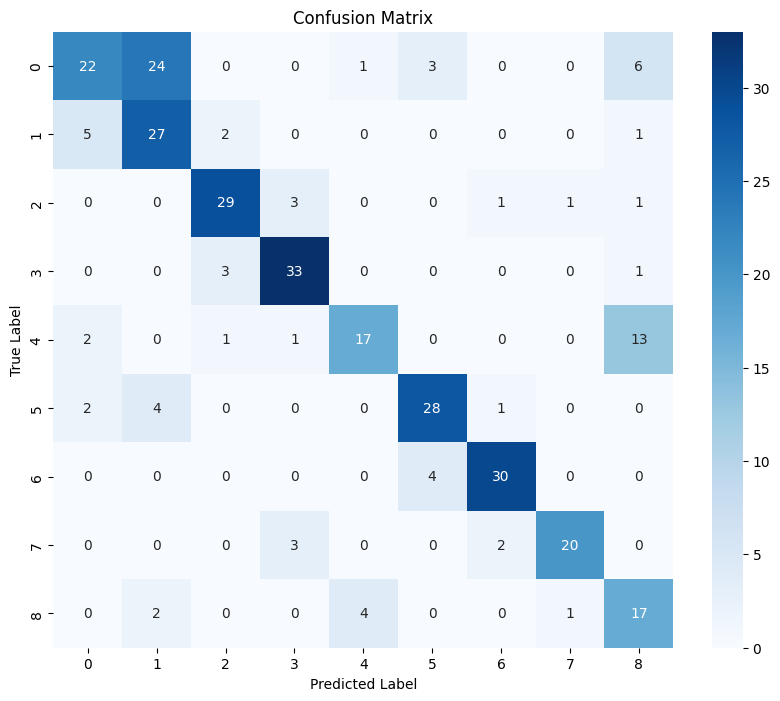

Accuracy:  0.707936507936508
Precision:  0.7374446241494079
Recall:  0.7306039232509821
              precision    recall  f1-score   support

         0.0       0.71      0.39      0.51        56
         1.0       0.47      0.77      0.59        35
         2.0       0.83      0.83      0.83        35
         3.0       0.82      0.89      0.86        37
         4.0       0.77      0.50      0.61        34
         5.0       0.80      0.80      0.80        35
         6.0       0.88      0.88      0.88        34
         7.0       0.91      0.80      0.85        25
         8.0       0.44      0.71      0.54        24

    accuracy                           0.71       315
   macro avg       0.74      0.73      0.72       315
weighted avg       0.74      0.71      0.71       315



In [23]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sns

classes = np.arange(0, 9)

y_pred = opt_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')


cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print(classification_report(y_test, y_pred_classes))

# Grid Search Results


## Without cleaning


#### CNN only
opt_model = build_cnn_model(dim_size=1, layer1=32, kernel1=(5,3), layer2=64, kernel2=(5,3),
                             denselayer=128, pool_size=(2,2),
                             layer_dropout=0.2, end_dropout=0.5, num_classes=9)

gets test accuracy of 81.2%

#### CNN into LSTM
model = build_full_model(dim_size=1, layer1=32, kernel1=(5,3), layer2=64, kernel2=(5,3),
                         pool_size=(2,2), lstm_size=64, denselayer=128, cnn_dropout=0.2,
                         lstm_dropout=0.2, end_dropout=0.5, num_classes=9)

78%

#### Parallel CNN and LSTM

model = build_full_parallel(dim_size=1, layer1=16, kernel1=(5,3), layer2=32, kernel2=(7,3),
                             pool_size=(2,2), lstm_size=64, cnn_dense=64, denselayer=128, cnn_dropout=0.3,
                             lstm_dropout=0.3, end_dropout=0.5, num_classes=9)

75.5%

## With Cleaning

### CNN Only

opt_model = build_cnn_model(dim_size=1, layer1=16, kernel1=(3,3), layer2=64,
                                 kernel2=(7,3), denselayer=128, pool_size=(2,2),
                                 layer_dropout = 0.5, end_dropout=0.5, num_classes=9)

72.3%

opt_model = build_cnn_model(dim_size=1, layer1=32, kernel1=(7,3), layer2=64,
                                 kernel2=(7,3), denselayer=128, pool_size=(2,2),
                                 layer_dropout = 0.3, end_dropout=0.5, num_classes=9)

76.2%

#### CNN Into LSTM

opt_model = build_full_model(dim_size=1, layer1=16, kernel1=(3,3), layer2=32,
                                 kernel2=(5,3), denselayer=128, pool_size=(2,2),
                                 lstm_size=64, cnn_dropout=0.3, lstm_dropout=0.3,
                                 end_dropout=0.5, num_classes=9)

80.6%

opt_model = build_full_model(dim_size=1, layer1=16, kernel1=(3,3), layer2=32,
                                 kernel2=(5,3), denselayer=128, pool_size=(2,2),
                                 lstm_size=32, cnn_dropout=0.4, lstm_dropout=0.4,
                                 end_dropout=0.4, num_classes=9)

81.9%

opt_model = build_full_model(dim_size=1, layer1=16, kernel1=(3,3), layer2=32,
                                 kernel2=(5,3), denselayer=128, pool_size=(2,2),
                                 lstm_size=128, cnn_dropout=0.3, lstm_dropout=0.4,
                                 end_dropout=0.5, num_classes=9)

81.6%

### Parallel Model
opt_model = build_full_parallel(dim_size=1, layer1=16, kernel1=(5,3), layer2=32,
                                 kernel2=(5,3), cnn_dense=128, denselayer=64, pool_size=(2,2),
                                 lstm_size=64, cnn_dropout=0.3, lstm_dropout = 0.4, end_dropout=0.5, num_classes=9)

81.2%

opt_model = build_full_parallel(dim_size=1, layer1=16, kernel1=(5,3), layer2=32,
                                 kernel2=(7,3), cnn_dense=64, denselayer=128, pool_size=(2,2),
                                 lstm_size=64, cnn_dropout=0.4, lstm_dropout = 0.3, end_dropout=0.5, num_classes=9)

81.5%

PCA Result Shape: (9, 3)


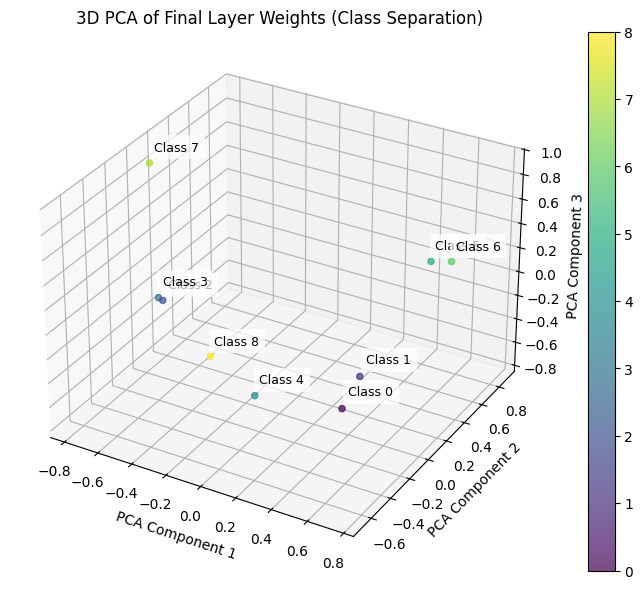

In [ ]:
# PCA on model parameters

class_labels = [f"Class {i}" for i in range(9)]

parallel_model = model.get_layer("functional_109")

final_layer = parallel_model.layers[-1]  # Last layer (typically classification)
final_layer_weights = final_layer.get_weights()[0]  # Only weights, not biases

# Each row is the weight vector for one class (transpose if necessary)
#model_parameters = final_layer_weights.reshape(final_layer_weights.shape[0], -1)
model_parameters = final_layer_weights.T


# Perform PCA on these class weight vectors
pca = PCA(n_components=3)
pca_result = pca.fit_transform(model_parameters)
print("PCA Result Shape:", pca_result.shape)  # (num_classes, 3)

# Visualizing in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
                c=np.arange(pca_result.shape[0]), cmap='viridis', alpha=0.7)

offset = 0.1
for i, label in enumerate(class_labels):
    ax.text(
        pca_result[i, 0] + offset, pca_result[i, 1] + offset, pca_result[i, 2] + offset,  # Coordinates
        label,                                                  # Text label
        fontsize=9,
        ha='center', va='center',
        bbox=dict(facecolor='white', alpha=0.7, lw=0)           # Optional: white background
    )
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA of Final Layer Weights (Class Separation)')
plt.colorbar(sc)
plt.show()

In [15]:
# save model
save_path = '/content/drive/MyDrive/cnn_lstm_cleaned_816.h5' # Specify the full path within your Google Drive
opt_model.save(save_path)
print(f"Model saved successfully to {save_path}")

Model saved successfully to /content/drive/MyDrive/cnn_lstm_cleaned_816.h5


In [ ]:
sorted_results = sorted(results, key=lambda x: x['val_acc'], reverse=True)

# Print the sorted results
for result in sorted_results:
    print(result)

{'dim_size': 1, 'layer1': 32, 'kernel1': (5, 3), 'layer2': 128, 'kernel2': (5, 3), 'denselayer': 128, 'pool_size': (2, 2), 'layer_dropout': 0.2, 'end_dropout': 0.4, 'batch_size': 128, 'epochs': 100, 'val_acc': 0.841269850730896}
{'dim_size': 1, 'layer1': 32, 'kernel1': (7, 3), 'layer2': 64, 'kernel2': (5, 3), 'denselayer': 128, 'pool_size': (2, 2), 'layer_dropout': 0.2, 'end_dropout': 0.5, 'batch_size': 128, 'epochs': 100, 'val_acc': 0.829365074634552}
{'dim_size': 1, 'layer1': 32, 'kernel1': (5, 3), 'layer2': 64, 'kernel2': (7, 3), 'denselayer': 128, 'pool_size': (3, 3), 'layer_dropout': 0.2, 'end_dropout': 0.5, 'batch_size': 128, 'epochs': 100, 'val_acc': 0.8134920597076416}
{'dim_size': 1, 'layer1': 32, 'kernel1': (5, 3), 'layer2': 64, 'kernel2': (5, 3), 'denselayer': 128, 'pool_size': (2, 2), 'layer_dropout': 0.1, 'end_dropout': 0.5, 'batch_size': 128, 'epochs': 100, 'val_acc': 0.7936508059501648}
{'dim_size': 1, 'layer1': 32, 'kernel1': (5, 3), 'layer2': 128, 'kernel2': (5, 3), 'd

In [ ]:
parallel_model = model.get_layer("functional_109")
final_layer = parallel_model.layers[-1]  # Last layer (typically classification)
final_layer_weights = final_layer.get_weights()[0]  # Only weights, not biases
print(final_layer_weights.shape)

(32, 9)


In [ ]:
opt_model.save('/content/drive/MyDrive/grid_search_84.h5')

In [ ]:
from tensorflow.keras.layers import Reshape, LSTM

def build_cnn_lstm(input_shape, num_classes=10):
  model = Sequential()

  model.add(Conv2D(16, (5, 3), activation='relu', padding='same', input_shape=input_shape))
  model.add(Conv2D(16, (5, 3), activation='relu', padding='same', input_shape=input_shape))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.1))

  model.add(Conv2D(32, (7, 3), activation='relu', padding='same'))
  model.add(Conv2D(32, (7, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.1))

  # Flattening CNN output
  model.add(Flatten())

  # Reshaping for LSTM (time steps, features)
  model.add(Reshape((-1, 32)))  # Adjust the second dimension based on your CNN output size

  # LSTM Layers (Temporal Sequence Learning)
  model.add(LSTM(32, return_sequences=True))
  model.add(LSTM(32))
  model.add(Dropout(0.2))

  # Dense Layers for Classification
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(9, activation='softmax'))  # Assuming 10 classes for classification

  return model

top_channels_model = build_cnn_lstm((101, 4, top_k), num_classes=10)
top_channels_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ (None, 101, 4, 16)     │         4,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 101, 4, 16)     │         3,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 50, 2, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 50, 2, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 50, 2, 32)      │        10,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 50, 2, 32)      │        21,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 25, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 25, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 25, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,329 (235.66 KB)

 Trainable params: 60,329 (235.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
batch_size = 64
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                                  restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=5, min_lr=0.00001)

top_channels_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist = top_channels_model.fit(X_train_top_channels, y_train, callbacks=[early_stopping, reduce_lr],
                 epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.1701 - loss: 2.1894 - val_accuracy: 0.1825 - val_loss: 2.1686 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1910 - loss: 2.1736 - val_accuracy: 0.1825 - val_loss: 2.1574 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2131 - loss: 2.1504 - val_accuracy: 0.1825 - val_loss: 2.1378 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2080 - loss: 2.1218 - val_accuracy: 0.1825 - val_loss: 2.0847 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2130 - loss: 2.0702 - val_accuracy: 0.1984 - val_loss: 2.0003 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2334 - loss: 2.0179 - val_accuracy: 0.2659 - val_loss: 1.9134 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2330 - loss: 1.9534 - 

In [ ]:
y_pred = top_channels_model.predict(X_test_top_channels)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_classes)
print(accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
0.6063492063492063


# More Notes

got a 67.6% accuracy when model that produced top results was 60%

For notes later:

In general validation loss is stayign quite high

full 11 x 11 kernels: 41.5%

11 x 11 -> 15 x 15: 54.6%

13 x 13 -> 19 x 19: 40%

13, 15 -> 19, 23: 33.7%

11-> 31: 59.4%

11 x 3 -> 31 x 5: 58.7%

11 x 5 -> 31 x 7: 65.1%

11 x 5 -> 51 x 7: 65.4%

11 x 5 -> 51 x 11: 66.3%

11 x 5 -> 51 x 9: 55.9%

31 x 5 -> 51 x 11: 60.3%

11 x 5, 31 x 9, 51 x 15: 50.8%

11 x 5, 31 x 9, 51 x 11: 55. 2%

41 x 5, 51 x 7: 46%

3 x 3 -> 11 x 5 -> 51 x 11: 55.6%

5 x 5 -> 11 x 5 -> 51 x 11: 61.6%

1 x 1 -> 11 x 5 -> 51 x 11: 64.8%

11 x 3, 3 x 2 -> 64.8%

In [ ]:
pca_model = build_cnn(input_shape=(51, 5, 32), num_classes=10)
pca_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "ConvClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 51, 5, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 51, 5, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 26, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 26, 3, 128)     │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 26, 3, 128)     │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 13, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3328)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       426,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,097,482 (4.19 MB)

 Trainable params: 1,097,482 (4.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training autoencoder + CNN

optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
batch_size = 128
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                                  restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=5, min_lr=0.00001)

pca_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

hist = pca_model.fit(X_pca_train, y_pca_train, callbacks=[early_stopping, reduce_lr],
                 epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 718ms/step - accuracy: 0.0955 - loss: 1068.4323 - val_accuracy: 0.0794 - val_loss: 57.5287 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1117 - loss: 29.4635 - val_accuracy: 0.1270 - val_loss: 2.2998 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.0868 - loss: 2.4491 - val_accuracy: 0.0992 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0872 - loss: 2.3063 - val_accuracy: 0.0992 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1046 - loss: 2.3258 - val_accuracy: 0.0992 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0944 - loss: 2.3026 - val_accuracy: 0.0992 - val_loss: 2.3026 - learning_rate: 0.0010
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1052 - loss: 2.3024 - val_acc

Below is the encoder + CNN separate

In [ ]:
epoched_total = epoched_total.transpose(2, 3, 1, 0)

print(epoched_total.shape)

(315, 5, 508, 256)


In [ ]:
epoched_total = epoched_total.reshape(-1, 508, 256)
print(epoched_total.shape)

(1575, 508, 256)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (51, 5, 256)

inputs = layers.Input(shape=input_shape)

# --- ENCODER ---
x = layers.Conv2D(128, (5, 1), activation='relu', padding='same', name='encoded_1')(inputs)
x = layers.Conv2D(64, (5, 1), activation='relu', padding='same')(x)
bottleneck = layers.Conv2D(32, (3, 1), activation='relu', padding='same', name='bottle')(x)

# --- DECODER ---
x = layers.Conv2D(64, (5, 1), activation='relu', padding='same')(bottleneck)
x = layers.Conv2D(128, (5, 1), activation='relu', padding='same')(x)
decoded = layers.Conv2D(256, (5, 1), activation='linear', padding='same')(x)
# Model
autoencoder = models.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 51, 5, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded_1 (Conv2D)              │ (None, 51, 5, 128)     │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 51, 5, 64)      │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottle (Conv2D)                 │ (None, 51, 5, 32)      │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 5, 64)      │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 51, 5, 128)     │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 5, 256)     │       164,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,656 (1.63 MB)

 Trainable params: 426,656 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_auto = specs.copy()
print(X_auto.shape)
#X_auto = (X_auto - np.mean(X_auto)) / np.std(X_auto)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                                  restore_best_weights=True)

autoencoder.fit(X_auto, X_auto,  # X is both input and target
                epochs=100,
                batch_size=16,
                validation_split=0.1,
                callbacks=[early_stopping],
                shuffle=True)

(1575, 51, 5, 256)
Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 5448995.0000 - val_loss: 239528.9688
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 896832.8125 - val_loss: 680031.3750
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 754874.0625 - val_loss: 531803.6250
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 869924.1875 - val_loss: 112888.0625
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1543751.5000 - val_loss: 124228.0156
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 376150.7812 - val_loss: 69096.9141
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 173946.2500 - val_loss: 254601.2969
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 435574.0000 - val_loss: 123940.1641
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 140764.4062 - val_loss: 32103.6738
Epoch 10/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 121947.8594 - val_loss: 148845.2344
Epoch 11/100
89/89 ━━━━━━

In [ ]:
# Extract encoder model
# Assume autoencoder is your trained model
encoder = models.Model(autoencoder.input, autoencoder.get_layer('bottle').output)

# Apply the encoder to your data (e.g., X_train)
decoded_data = encoder.predict(specs)
#decoded_data = decoded_data.transpose(0, 2, 1)

decoded_data.shape

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


(1575, 51, 5, 32)

In [ ]:
del X_auto
gc.collect()

1377

In [ ]:
# @title
import numpy as np
from scipy.signal import spectrogram

def compute_spectrograms(data, fs=500, nperseg=25, noverlap=10):
    """
    Compute spectrograms for each (trial, channel) in EEG data.

    Parameters:
    - data: shape (num_samples, num_channels, num_timepoints)
    - fs: sampling frequency
    - nperseg: window size for FFT
    - noverlap: number of points to overlap between segments

    Returns:
    - specs: numpy array of shape (num_samples, num_channels, num_freq_bins, num_time_windows)
    """
    num_samples, num_channels, num_timepoints = data.shape

    # Use one example to get spectrogram shape
    freqs, times, Sxx_ = spectrogram(data[0, 0], fs=fs, nperseg=nperseg, noverlap=noverlap)
    num_freqs = len(freqs)
    num_windows = len(times)

    # Initialize output array
    specs = np.zeros((num_samples, num_channels, num_freqs, num_windows), dtype=np.float32)

    for i in range(num_samples):
        for ch in range(num_channels):
            _, _, Sxx = spectrogram(data[i, ch], fs=fs, nperseg=nperseg, noverlap=noverlap)
            specs[i, ch] = Sxx

    return specs

In [ ]:
# @title
specs = compute_spectrograms(decoded_data, nperseg=50, noverlap=0)
print(specs.shape)
specs.shape

(1575, 32, 26, 10)


(1575, 32, 26, 10)

In [ ]:
# @title
specs = specs.transpose(0, 2, 3, 1)
print(specs.shape)

y_left = np.tile(np.arange(5), left_trials)
y_right = np.tile(np.arange(5, 10), right_trials)
y = np.concatenate((y_left, y_right), axis=0)
print(y.shape)

# seeing if accuracy is better with 5 classes
y_full = np.tile(np.arange(5), total_trials)
print(y_full.shape)

X_train, X_test, y_train, y_test = train_test_split(specs, y_full, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1575, 26, 10, 32)
(1575,)
(1575,)
(1260, 26, 10, 32)
(315, 26, 10, 32)
(1260,)
(315,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(specs, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1260, 51, 5, 256)
(315, 51, 5, 256)
(1260,)
(315,)


In [ ]:
del specs, y
gc.collect()

28010

In [ ]:
# 2D CNN for training on spectrograms
input_shape = (51, 5, 32)
output_shape = 5

cnn = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(1024, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(1024, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
        layers.Dropout(0.1),
        layers.Conv2D(2048, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(2048, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(1024, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(output_shape, activation="softmax"),
    ]
)

cnn.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)              │ (None, 51, 5, 512)     │       147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 51, 5, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 25, 2, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 25, 2, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 25, 2, 1024)    │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 25, 2, 1024)    │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 13, 1, 1024)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 13, 1, 1024)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 13, 1, 2048)    │    18,876,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 13, 1, 2048)    │    37,750,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 7, 1, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 7, 1, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 14336)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │    14,681,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,979,013 (335.61 MB)

 Trainable params: 87,979,013 (335.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# @title
# LSTM
input_shape = (13, 33, 32)  # (time, freq, channels)
output_shape = 5

lstm = keras.Sequential([
    # Input shape: (51 time steps, 5 freq bins, 256 channels)
    layers.Input(shape=input_shape),

    # 1. Frequency-domain processing (applied per time step)
    layers.TimeDistributed(layers.Conv1D(32, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.Conv1D(32, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.MaxPooling1D(2)),
    #layers.TimeDistributed(layers.Dropout(0.1)),

    # 2. Deeper frequency processing
    layers.TimeDistributed(layers.Conv1D(64, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.Conv1D(64, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.MaxPooling1D(2)),
    layers.TimeDistributed(layers.Dropout(0.1)),

    layers.TimeDistributed(layers.Conv1D(128, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.Conv1D(128, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.MaxPooling1D(2, padding='same')),
    layers.TimeDistributed(layers.Dropout(0.15)),

    # 3. Prepare for LSTM - output will be (None, 51, remaining_features)
    layers.TimeDistributed(layers.Flatten()),

    # 4. Temporal processing
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dropout(0.4),

    # 5. Classifier
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(output_shape, activation='softmax')
])

lstm.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_221            │ (None, 13, 33, 32)     │         3,104 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_222            │ (None, 13, 33, 32)     │         3,104 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_223            │ (None, 13, 16, 32)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_224            │ (None, 13, 16, 64)     │         6,208 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_225            │ (None, 13, 16, 64)     │        12,352 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_226            │ (None, 13, 8, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_227            │ (None, 13, 8, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_228            │ (None, 13, 8, 128)     │        24,704 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_229            │ (None, 13, 8, 128)     │        49,280 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_230            │ (None, 13, 4, 128)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_231            │ (None, 13, 4, 128)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_232            │ (None, 13, 512)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_30                │ (None, 13, 256)        │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_31                │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 5)              │           64

 Total params: 1,182,917 (4.51 MB)

 Trainable params: 1,182,917 (4.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# training the model
from tensorflow.keras.optimizers import Adam
#y_train = tf.keras.utils.to_categorical(y, num_classes=5) # use if we want labels to be on-hot encoded

optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
batch_size = 256
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                                  restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=5, min_lr=0.00001)

cnn.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
hist = cnn.fit(X_train, y_train, callbacks=[early_stopping, reduce_lr],
                 epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.1888 - loss: 8490.3330 - val_accuracy: 0.2222 - val_loss: 1.6274 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step - accuracy: 0.2205 - loss: 1.6330 - val_accuracy: 0.2063 - val_loss: 1.6163 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 477ms/step - accuracy: 0.2167 - loss: 1.6132 - val_accuracy: 0.2063 - val_loss: 1.6128 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - accuracy: 0.2277 - loss: 1.6675 - val_accuracy: 0.1984 - val_loss: 1.6071 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - accuracy: 0.2273 - loss: 1.6154 - val_accuracy: 0.2460 - val_loss: 1.6199 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step - accuracy: 0.2292 - loss: 1.5971 - val_accuracy: 0.2778 - val_loss: 1.6065 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 0.2613 - loss: 1.5877 - val_ac

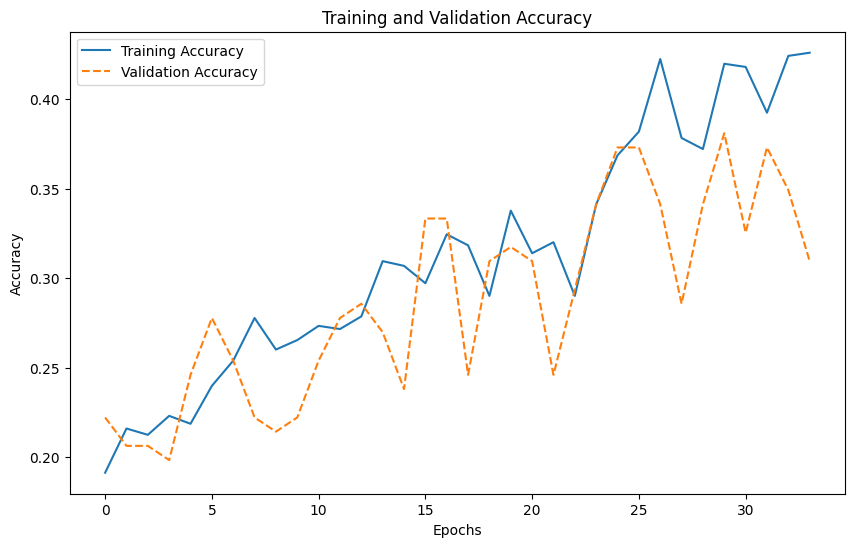

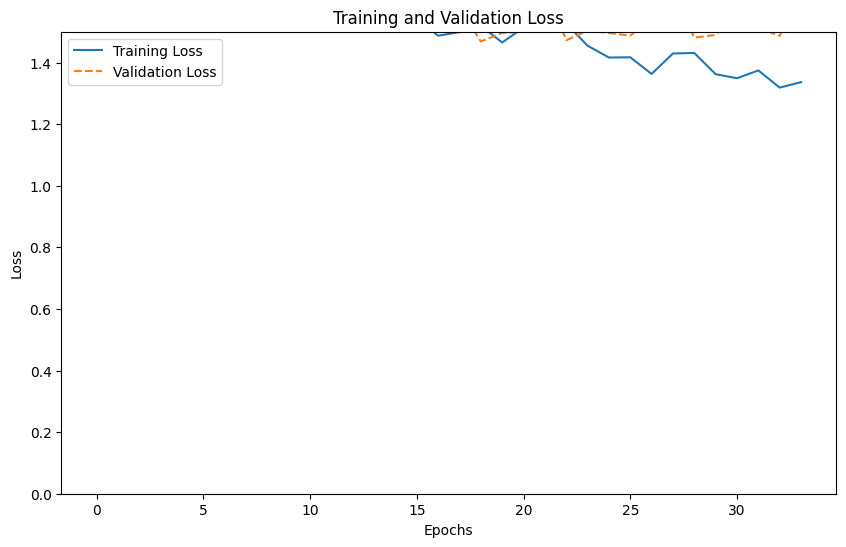

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
0.31746031746031744


In [ ]:
from sklearn.metrics import accuracy_score
import pandas as pd

history_df = pd.DataFrame(hist.history)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], linestyle='--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], linestyle='--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0, 1.5)
plt.legend()
plt.show()

y_pred =cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_classes)
print(accuracy)

In [ ]:
# @title
import tensorflow as tf
from tensorflow.keras.layers import Layer

# class to support creating spectrograms within tf
class EEGSpectrogramLayer(Layer):
    def __init__(self, fs=500, nperseg=100, noverlap=0, **kwargs):
        super(EEGSpectrogramLayer, self).__init__(**kwargs)
        self.fs = fs
        self.nperseg = nperseg
        self.noverlap = noverlap

    def call(self, inputs):
        def _compute_spec(x_np):
            specs = []
            for i in range(x_np.shape[0]):  # loop over neurons
                f, t, Sxx = scipy.signal.spectrogram(
                    x_np[i],
                    fs=self.fs,
                    nperseg=self.nperseg,
                    noverlap=self.noverlap,
                )
                specs.append(Sxx)
            return np.stack(specs, axis=-1)  # Shape: (freq, time, neurons)

        specs = tf.numpy_function(_compute_spec, [inputs], tf.float32)
        specs.set_shape([None, None, inputs.shape[0]])  # freq, time, channels
        return specs


In [ ]:
'''Other ideas:
Need to experiment with different numbers of classes.
Can we edit Mike's functions to get more data for each dataset?

pass data through BPF before making the spectorgram to get rid of anything more than 500 hz
WE ARE USING LPFs NOT EEGs
'''

In [ ]:
#specs = compute_eeg_spectrograms(epoched_total)
specs_left = compute_eeg_spectrograms(epoched_left)
specs_right = compute_eeg_spectrograms(epoched_right)
#print(specs.shape)
print(specs_left.shape)
print(specs_right.shape)

(775, 256, 51, 5)
(800, 256, 51, 5)


In [ ]:
X_left = specs_left.transpose(0, 2, 3, 1)
y_left = np.repeat(np.arange(0, 5), epoched_left.shape[2])
X_right = specs_right.transpose(0, 2, 3, 1)
y_right = np.repeat(np.arange(5, 10), epoched_right.shape[2])
X_total = np.concatenate((X_left, X_right), axis=0)
y_total = np.concatenate((y_left, y_right), axis=0)
print(X_total.shape)
print(y_total.shape)
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)

(1575, 51, 5, 256)
(1575,)


In [ ]:
del specs_left, specs_right, X_left, X_right, y_left, y_right, X_total, y_total
gc.collect()

8098

In [ ]:
# @title
#epoched_total = epoched_total.transpose(0, 3, 1, 2).reshape(-1, 508, total_trials)
#y = np.repeat(np.arange(5), 256)
#X = epoched_total.reshape(-1, 508, 35)  # Separates data by electrode
#y = np.repeat(np.arange(5), 256)  # Labels: [0,0,0,...,1,1,1,...,4,4,4]

#X = epoched.transpose(2, 3, 0, 1).reshape(-1, 256, 508)  # separates by trial
#y = np.tile(np.arange(5), 35)  # Labels: [0, 1, 2, 3, 4, 0, 1, 2, ...]

#print("New X shape:", epoched_total.shape)  # (1280, 508, 35)
#print("New y shape:", y.shape)  # (1280,)
#epoched_total = epoched_total[..., np.newaxis]

#epoched_left = epoched_left.transpose(0, 3, 1, 2).reshape(-1, 508, epoched_left.shape[2])
y_left = np.repeat(np.arange(0, 10, 2), 256)

#epoched_right = epoched_right.transpose(0, 3, 1, 2).reshape(-1, 508, epoched_right.shape[2])
y_right = np.repeat(np.arange(1, 10, 2), 256)

min_trials = min(epoched_left.shape[2], epoched_right.shape[2])

# Truncate both arrays to the minimum number of trials
epoched_left = epoched_left[:, :, :min_trials]
epoched_right = epoched_right[:, :, :min_trials]

epoched_total = np.concatenate((epoched_left, epoched_right), axis=2)
y = np.concatenate((y_left, y_right), axis=0)

X_train, X_test, y_train, y_test = train_test_split(epoched_total, y, test_size=0.2, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [1280, 2560]

In [ ]:
# @title
# 1D CNN architecture that trains directly on data loaded using Mike's functions

input_shape = (508, total_trials)
output_shape = 5

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv1D(128, kernel_size=3, activation="relu", padding="same"),
        layers.Conv1D(128, kernel_size=5, activation="relu", padding="same"),
        layers.Conv1D(128, kernel_size=7, activation="relu", padding="same"),
        layers.Dropout(0.75),
        layers.MaxPooling1D(pool_size=3),
        layers.Conv1D(256, kernel_size=3, activation="relu", padding="same"),
        layers.Conv1D(256, kernel_size=5, activation="relu", padding="same"),
        layers.Dropout(0.75),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(512, kernel_size=3, activation="relu", padding="same"),
        layers.Dropout(0.75),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.75),
        layers.Dense(output_shape, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 508, 128)            │         121,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 508, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 508, 128)            │         114,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 508, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 169, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 169, 256)            │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 169, 256)            │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 169, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 84, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 84, 512)             │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 84, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 42, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 21504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │      11,010,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,151,301 (46.35 MB)

 Trainable params: 12,151,301 (46.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 2D CNN for training on spectrograms
input_shape = (51, 5, 256)
output_shape = 10

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        #layers.Dropout(0.15),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        #layers.Dropout(0.15),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
        #layers.Dropout(0.15),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
        #layers.Dropout(0.15),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.25),
        layers.Dense(output_shape, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 51, 5, 64)      │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 51, 5, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 25, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 25, 2, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 25, 2, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 12, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 12, 1, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 12, 1, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 6, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 6, 1, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 6, 1, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 3, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,029,130 (19.18 MB)

 Trainable params: 5,029,130 (19.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
input_shape = (51, 5, 256)  # (time, freq, channels)
output_shape = 10

model = keras.Sequential([
    # Input shape: (51 time steps, 5 freq bins, 256 channels)
    layers.Input(shape=input_shape),

    # 1. Frequency-domain processing (applied per time step)
    layers.TimeDistributed(layers.Conv1D(32, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.Conv1D(32, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.MaxPooling1D(2)),
    layers.TimeDistributed(layers.Dropout(0.2)),

    # 2. Deeper frequency processing
    layers.TimeDistributed(layers.Conv1D(64, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.Conv1D(64, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.MaxPooling1D(2)),
    layers.TimeDistributed(layers.Dropout(0.25)),

    layers.TimeDistributed(layers.Conv1D(128, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.Conv1D(128, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.MaxPooling1D(2, padding='same')),
    layers.TimeDistributed(layers.Dropout(0.3)),

    # 3. Prepare for LSTM - output will be (None, 51, remaining_features)
    layers.TimeDistributed(layers.Flatten()),

    # 4. Temporal processing
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dropout(0.5),

    # 5. Classifier
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(output_shape, activation='softmax')
])

model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_112            │ (None, 51, 5, 32)      │        24,608 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_113            │ (None, 51, 5, 32)      │         3,104 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_114            │ (None, 51, 2, 32)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_115            │ (None, 51, 2, 32)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_116            │ (None, 51, 2, 64)      │         6,208 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_117            │ (None, 51, 2, 64)      │        12,352 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_118            │ (None, 51, 1, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_119            │ (None, 51, 1, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_120            │ (None, 51, 1, 128)     │        24,704 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_121            │ (None, 51, 1, 128)     │        49,280 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_122            │ (None, 51, 1, 128)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_123            │ (None, 51, 1, 128)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_124            │ (None, 51, 128)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 51, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 846,026 (3.23 MB)

 Trainable params: 846,026 (3.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# training the model
from tensorflow.keras.optimizers import Adam
#y_train = tf.keras.utils.to_categorical(y, num_classes=5) # use if we want labels to be on-hot encoded

optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
batch_size = 128
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                                  restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=5, min_lr=0.00001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
hist = model.fit(X_train, y_train, callbacks=[early_stopping, reduce_lr],
                 epochs=epochs, batch_size=batch_size, validation_split=0.10)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.0838 - loss: 2.3207 - val_accuracy: 0.0873 - val_loss: 2.3091 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.1250 - loss: 2.3003 - val_accuracy: 0.0952 - val_loss: 2.2986 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.1022 - loss: 2.3014 - val_accuracy: 0.0714 - val_loss: 2.3046 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.1139 - loss: 2.2866 - val_accuracy: 0.1587 - val_loss: 2.2810 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.1470 - loss: 2.2490 - val_accuracy: 0.1270 - val_loss: 2.2095 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.1538 - loss: 2.2269 - val_accuracy: 0.1667 - val_loss: 2.1665 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.2023 - loss: 2.1761 - val_accur

In [ ]:
'''
Saving best spectorgram results here
separating labels for left and right top accuracy is 56.8%
10 labels and LSTM -best is 67.9%
generally got about 80% with different models using all data and 5 classes
'''
best_spec_accuracy = accuracy_score(y_test, y_pred_classes)
print(best_spec_accuracy)

0.7968253968253968


In [ ]:
''' Saving metrics of best accuracy
 combining all datasets, X is separated by electron
 note: with 10 million parameters got 86.7% accuracy
 and with 5 million 86.3%

optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
batch_size = 128
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                                  restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.85,
                              patience=10, min_lr=0.00001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
hist = model.fit(X_train, y_train, callbacks=[early_stopping, reduce_lr],
                 epochs=epochs, batch_size=batch_size, validation_split=0.10)
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.05),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.05),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.05),
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.10),
        layers.Dense(output_shape, activation="softmax"),
    ]
)'''

best_accuracy = accuracy_score(y_test, y_pred_classes)
print(best_accuracy)

0.86328125


In [ ]:
# Best accuracies for differnet parameter numbers
# Note: 5 and 10 million use 2D
best_5_million = 0.863
best_10_million = 0.867
best_12_million = 0.82
best_3_million = 0.852
best_1_1_million = 0.84
best_780K = 0.848
best_600K = 0.852
best_550K = 0.84
best_376K = 0.848
best_285K = 0.82
# Overfitting seems to be less of a problem around here
best_200K = 0.84
best_98K = 0.796
best_76K = 0.793
best_54K = 0.801
best_37K = 0.77
best_26K = 0.84
best_15K =  0.781
best_12K = 0.801
best_4K = 0.738

In [ ]:
# Code to save model if/when needed
import pickle

save_path = '/content/drive/MyDrive/grid_search_84.pkl' # Remember to change file name

with open(save_path, 'wb') as file:
    pickle.dump(opt_model, file)

In [ ]:
#  New FFT functions
from scipy.signal import spectrogram
print(epoched_total.shape)
X_multichannel = epoched_total.reshape(1575, 508, 256, 1) #.reshape(130048, 175, 1) Ensure the shape matches (508, 35, 1)

X = epoched_total.transpose(2, 3, 0, 1).reshape(-1, 256, 508)  # (175, 256, 508)
y_multichannel = np.tile(np.arange(5), 315)  # Labels: [0, 1, 2, 3, 4, 0, 1, 2, ...]

print("New X shape:", X_multichannel.shape)  # (175, 256, 508)
print("New y shape:", y_multichannel.shape)  # (175,)

def compute_eeg_fft_spectrogram(eeg_data, fs=250, window_size=25, step_size=10, fmax=50):
  num_channels, num_samples = eeg_data.shape
  freqs = np.fft.rfftfreq(window_size, d=1/fs)
  max_bin = np.argmax(freqs > fmax) if np.any(freqs > fmax) else len(freqs)
  num_windows = (num_samples - window_size) // step_size + 1
  spec = np.zeros((num_channels, max_bin, num_windows))

  for ch in range(num_channels):
    for i in range(num_windows):
      start = i * step_size
      end = start + window_size
      segment = eeg_data[ch, start:end]
      fft_vals = np.abs(rfft(segment))[:max_bin]
      spec[ch, :, i] = fft_vals

  return spec, freqs[:max_bin]

fmax = 50

ffts_images = []
for i in range(X.shape[0]):# Get a longer EEG window (1 second)
  real_epoched = X[i, :, :, 0].T  # (channels, samples)

  fft_img = compute_eeg_fft_spectrogram(real_epoched, fs=250, window_size=25, step_size=10, fmax=50)[0]
  ffts_images.append(fft_img)

plt.figure(figsize=(10, 6))
plt.imshow( np.log1p(spectrogram[0]), origin='lower', aspect='auto',
    cmap='viridis', extent=[0, spectrogram.shape[2], 0, spectrogram.shape[1]])
plt.title(f"Spectrogram - Channel {ch_idx}")
plt.xlabel("Time Window")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Log Magnitude")
plt.tight_layout()
plt.show()

(256, 508, 315, 5)
New X shape: (1575, 508, 256, 1)
New y shape: (1575,)


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed